# Pratical Session : Stochastic Bandits

Code adapted from https://github.com/yfletberliac/rlss-2019 (Practical Sessions of RLSS 2019: Bandits, RL & Deep RL. https://rlss.inria.fr/program/)

In [1]:
import sys
sys.path.insert(0,'Utils')

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import time
from scipy.optimize import linprog


# Bandit specific functions and classes 
import Utils.Arms as arm
from Utils.StochasticBandit import *
from Utils.BanditTools import * 
import Utils.BanditBaselines as alg

# Part 1 :  Unstructured Stochastic Bandits

We study the classical multi-armed bandit problem specified by a set of real-valued
distributions $ (\nu_a)_{a \in \mathcal{A}}$ with means $(\mu_a)_{a \in \mathcal{A}} \in \mathbb{R}^\mathcal{A}$, where $\mathcal{A}$ is a finite set of arms. 

At each time $t \geq 1$, a learner must choose an arm $a_t \in \mathcal{A}$, based only on
the past. The learner then receives and observes a reward $X_t$ sampled according to $\nu_{a_t}$. The goal of the learner is simply to maximize the expected sum of rewards received over time, or equivalently minimize regret
with respect to the strategy constantly receiving the highest mean reward.

On a  bandit instance, the Lai and Robbins lower bound tells us that the regret is **asymptotically** no smaller than 

$$\left(\sum_{a \in \mathcal{A}} \frac{\Delta_a}{\mathrm{KL}(\mu_a,\mu_\star)}\right) \log(T),$$
where $\mathrm{KL}(\mu_a,\mu_\star)$ is the KL-divergence between the distribution of mean $\mu_a$ and the distribution of mean $\mu_\star$. The constant in front of the $\log(T)$ may be called the **complexity** of the bandit problem.

####  Creating a bandit environnement

Different arm classes are defined in `Arms.py` (you are welcome to add more!). To define a multi-armed bandit (a `MAB` object), you need to input a list of such arms. Some functions in `StochasticBandits.py` also define directly some particular MAB objects. 

In [8]:
nbArms = 3
bandit = GaussianBandit([-1, 0, 1]) # directly creates a Gaussian bandit from a vector of means

print("The means of bandit instance are", bandit.means)

The means of bandit instance are [-1, 0, 1]


#### Executing strategy

The function given below executes one bandit algorithm on one MAB instance. 

In [10]:
def OneBanditOneLearnerOneRun(bandit, learner, timeHorizon):
    """
    Run a bandit strategy (learner) on a MAB instance (bandit) for (timeHorizon) time steps
    output : sequence of arms chosen, sequence of rewards obtained
    """
    selections = []
    rewards = []
    learner.clear() # reset previous history
    for t in range(timeHorizon):
        arm = learner.chooseArmToPlay()
        reward = bandit.generateReward(arm)
        learner.receiveReward(arm, reward)
        # Update statistics
        selections.append(arm)
        rewards.append(reward)
    return selections, rewards
    
def CumulativeRegret(bandit,selections):
    """Compute the pseudo-regret associated to a sequence of arm selections"""
    return np.cumsum(max(bandit.means)*np.ones(len(selections)) - np.array(bandit.means)[selections])

#### Comparison averaged over multiple runs

The regret is defined as an **expectation**, so we need several runs to **estimate** its value. We can also take a look at the distribution of the pseudo-regret. The function below gathers results accross multiple runs.

In [11]:
def OneBanditOneLearnerMultipleRuns(bandit, learner, timeHorizon, N_exp, tsave=[]):
    if (len(tsave) == 0):
        tsave = np.arange(timeHorizon)
    savedTimes = len(tsave)
    Regret = np.zeros((N_exp, savedTimes)) # Store the regret values on different runs
    for n in range(N_exp):
        np.random.seed()
        selections, rewards = OneBanditOneLearnerOneRun(bandit, learner, timeHorizon)
        regret_one_run = CumulativeRegret(bandit, selections)
        Regret[n, :] = np.array(regret_one_run)[tsave] # Store a sub-sampling of the cumulative regret
    return Regret

## I. Trivial Strategies : Follow The Leader (FTL) and Uniform Exploration (UE)

We first implemented two strategies for unstructured stochastic bandits: the Follow The Leader algorithm (`FTL`) and the Uniform Exploration algorithm (`UE`). Such strategies (as the one you will implement) are defined as objects in `BanditBaselines.py`.

 Below we run `FTL` on the bandit instance introduced before, and visualize its behavior.

In [12]:
timeHorizon = 500
# nbArms = 7
# bandit = GaussianBandit([-1, 0, 1, 2, 3, 3, 2]) # directly creates a Gaussian bandit from a vector of means
nbArms = 3
bandit = GaussianBandit([-1, 0, 1]) # directly creates a Gaussian bandit from a vector of means

FTLlearner = alg.FTL(nbArms)

selections, rewards = OneBanditOneLearnerOneRun(bandit, FTLlearner, timeHorizon)
regret = CumulativeRegret(bandit, selections)

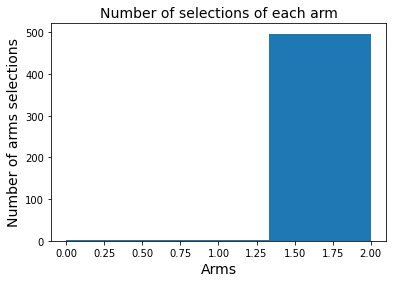

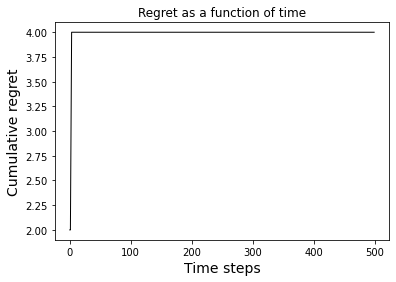

In [13]:
# Visualize results (on one run) 

# Histogram of the number of arms selections
plt.clf()
plt.xlabel("Arms", fontsize=14)
plt.ylabel("Number of arms selections", fontsize=14)
plt.hist(selections, max(selections) + 1)
plt.title("Number of selections of each arm", fontsize=14)
# plt.savefig('./Figure/test'+ learner.name() + '.pdf')

# Cumulative regret as a function of time
plt.figure(2)
plt.clf()
plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Cumulative regret", fontsize=14)
plt.title("Regret as a function of time")
plt.plot(range(timeHorizon), regret, 'black', linewidth=1)

We now compare FTL and UE algorithms on a single run. If you run this code multiple time, you will have very different results.

FTL is not always stable, sometimes it finds the right answer, but sometimes it does not which means it irreversibly continues to ignore the good answer.

In [42]:
UElearner = alg.UE(nbArms)

# Run the two learners
selections, rewards = OneBanditOneLearnerOneRun(bandit, FTLlearner, timeHorizon)
FTLregret = CumulativeRegret(bandit, selections)
selections, rewards = OneBanditOneLearnerOneRun(bandit, UElearner, timeHorizon)
UEregret = CumulativeRegret(bandit, selections)

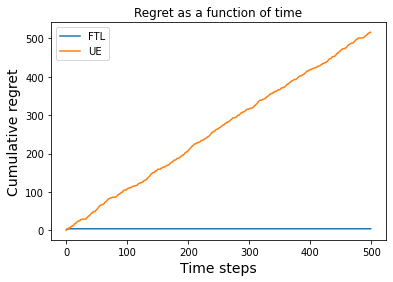

In [43]:
# Compare their regret
plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Cumulative regret", fontsize=14)
plt.title("Regret as a function of time")
plt.plot(range(0, timeHorizon), FTLregret,label=FTLlearner.name())
plt.plot(range(0, timeHorizon), UEregret,label=UElearner.name())
plt.legend()

We now compare FTL and UE algorithms on a multiple runs. If you run this code multiple time, you will have similar results.

In [46]:
N_exp = 1000
timeHorizon = 1000
tsave = np.arange(1, timeHorizon, 10)

FTLregret = OneBanditOneLearnerMultipleRuns(bandit, FTLlearner, timeHorizon, N_exp, tsave)
UEregret = OneBanditOneLearnerMultipleRuns(bandit, UElearner, timeHorizon, N_exp, tsave)
LBregret = complexity(bandit)*np.array([log(t) for t in tsave ])

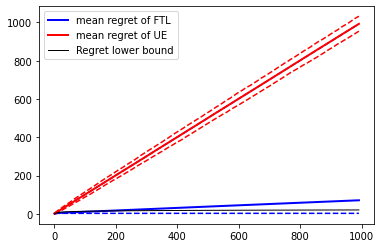

In [47]:
plt.clf()
plt.plot(tsave, np.mean(FTLregret, 0), linewidth=2.0, color="b", label="mean regret of "+FTLlearner.name())
plt.plot(tsave, np.quantile(FTLregret, 0.95, 0), tsave, np.quantile(FTLregret,0.05,0), linestyle="dashed", color="b")
plt.plot(tsave, np.mean(UEregret, 0), linewidth=2.0, color="r", label="mean regret of "+UElearner.name())
plt.plot(tsave, np.quantile(UEregret, 0.95, 0), tsave, np.quantile(UEregret,0.05,0), linestyle="dashed", color="r")
plt.plot(tsave, LBregret, linewidth=1.0, color="k", label="Regret lower bound")
plt.legend()
plt.show()

#### Question

* Do you think that FTL is a "safe" strategy ? 

## II. Index Based Strategies



For all arm $a \in \mathcal{A}$, for all time step  $t \geq 1$, the empirical mean of arm $a$ at time step $t$ is $$\hat \mu_a(t) = \dfrac{1}{N_a(t)} \sum\limits_{s = 1}^t \mathbb{1}_{\{a_s = a\}}X_s, \text{ if } N_a(t) > 0,\ 0 \text{ otherwise}, $$
where $N_a(t) = \sum\limits_{ s=1}^t \mathbb{1}_{\{ a_s = a\}}$ is the number of pulls of arm $a$ at time $t$. We denote by $\hat \mu_\star(t) = \max\limits_{a \in \mathcal{A}}\hat\mu_a(t)$.

### II.1. Upper Confidence Bound (UCB)

For an arm $a \in \mathcal{A}$ and a time step $t\geq 1$, the Upper Confidence Bound is defined as foollows:
$$ U_a(t) = \hat\mu_a(t)+ \sqrt{\frac{\log\!\left(1/\delta_t\right)}{2N_a(t)}} \,, $$
with $ \delta_t=t^{-2}(t+1)^{-1}$.


UCB is the strategy that consists in pulling an arm with maximal upper confidence bound at each time step:
$$ a_{t+1} = \arg\!\max_{a \in \mathcal{A}}U_a(t)  \,.$$

#### Questions

* Implement the UCB algorithm

* Compare the FTL and UCB algorithms, including the asymptotic lower bound

* Study the influence of the minimum gap, of the choice of $\delta_t$

In [95]:
def delta(t):
    return t**(-2)*(t+1)**(-1)

UCBlearner = alg.UCB(nbArms, delta)


UCBregret = OneBanditOneLearnerMultipleRuns(bandit, UCBlearner, timeHorizon, N_exp, tsave)

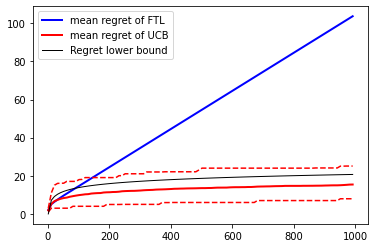

In [96]:
plt.clf()
plt.plot(tsave, np.mean(FTLregret, 0), linewidth=2.0, color="b", label="mean regret of "+FTLlearner.name())
#plt.plot(tsave, np.quantile(FTLregret, 0.95, 0), tsave, np.quantile(FTLregret,0.05,0), linestyle="dashed", color="b")
plt.plot(tsave, np.mean(UCBregret, 0), linewidth=2.0, color="r", label="mean regret of "+UCBlearner.name())
plt.plot(tsave, np.quantile(UCBregret, 0.95, 0), tsave, np.quantile(UCBregret,0.05,0), linestyle="dashed", color="r")
plt.plot(tsave, LBregret, linewidth=1.0, color="k", label="Regret lower bound")
plt.legend()
plt.show()

If there was more choices and there is no new thing to discover (like all the values are nearly the same {repetition of -1 0 1}), UCB doesn't perform well, since it loses a lot of time in the search process

### II.2. Index Minimum Empirical Divergence (IMED)

For an arm $a \in \mathcal{A}$ and a time step $t\geq 1$, the IMED index is defined as foollows:
$$ I_a(t) = N_a(t)\,\mathrm{KL}\!\left(\hat\mu_a(t),\hat \mu_\star(t)\right)+ \log\!\left(N_a(t)\right) \,. $$

This quantity can be seen as a transportation cost for “moving" a sub-optimal arm to an optimal one,
plus exploration terms (the logarithms of the numbers of pulls). When an optimal arm is considered,
the transportation cost is null and it remains only the exploration part. Note that, as stated in Honda
and Takemura (2011), $I_a(t)$ is an index in the weaker sense since it cannot be determined only
by samples from the pair $a$ but also uses empirical means of current optimal arms.

IMED is the strategy that consists in pulling an arm with minimal index at each time step:
$$ a_{t+1} = \arg\!\min_{a \in \mathcal{A}}I_a(t)  \,.$$

#### Questions

* Implement the IMED algorithm

* Compare the UCB and IMED algorithms, including the asymptotic lower bound

* Study the influence of the type of the distributions (Gaussian, Bernoulli, Exponential)

In [14]:
IMEDlearner = alg.IMED(nbArms, klGauss)


IMEDregret = OneBanditOneLearnerMultipleRuns(bandit, IMEDlearner, timeHorizon, N_exp, tsave)

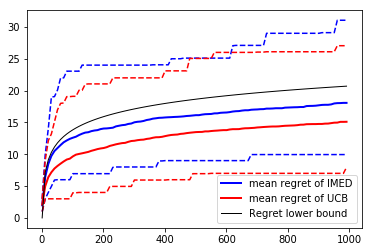

In [15]:
plt.clf()
plt.plot(tsave, np.mean(IMEDregret, 0), linewidth=2.0, color="b", label="mean regret of "+IMEDlearner.name())
plt.plot(tsave, np.quantile(IMEDregret, 0.95, 0), tsave, np.quantile(IMEDregret,0.05,0), linestyle="dashed", color="b")
plt.plot(tsave, np.mean(UCBregret, 0), linewidth=2.0, color="r", label="mean regret of "+UCBlearner.name())
plt.plot(tsave, np.quantile(UCBregret, 0.95, 0), tsave, np.quantile(UCBregret,0.05,0), linestyle="dashed", color="r")
plt.plot(tsave, LBregret, linewidth=1.0, color="k", label="Regret lower bound")
plt.legend()
plt.show()

## III. Sampling Based Strategies 

For all arm $a \in \mathcal{A}$, for all time step  $t \geq 1$, the cumulative reward from arm $a$ at time $t$ is $$S_a(t) = \sum\limits_{s = 1}^t \mathbb{1}_{\{a_s = a\}}X_s\,, $$
and the number of pulls of arm $a$ at time $t$ is 
$$N_a(t) = \sum\limits_{ s=1}^t \mathbb{1}_{\{ a_s = a\}} \,.$$

### III.1. Thomson Sampling (TS)

In a Bayesian view on the MAB, the $(\mu_a)_{a\in\mathcal{A}}$ are no longer seen as unknown parameters but as (independent)random variables following a uniform distribution. The posterior distribution on the arm $a$ at time $t$ of the bandit game is the distribution of $\mu_a$ conditional to the observations from arm $a$ gathered up to
time $t$ and it is denoted $\pi_a(t)$ . Each sample from arm $a$ leads to an update of this posterior distribution.


TS is the strategy that consists in drawing $\theta_a(t)\sim \pi_a(t)=Beta(N_a(t) + 1, N_a(t) - S_a(t) + 1)$ at time step t and for each arm $a$, then pulling the arm:
$$ a_{t+1} = \arg\!\max_{a \in \mathcal{A}}\theta_a(t)  \,.$$ 

#### Questions

* Implement the TS algorithm for Bernoulli distributions. You can make use of the Beta distribution `np.random.beta()`

* Compare the TS and IMED algorithms, including the asymptotic lower bound

### III.2. Best Empirical Sampled Average (BESA) [ 2 arms ]

If arm a has been pulled 3 times at time t, and arm b has been pulled 10 times, the
algorithm sub-samples 3 observations out of the 10 of arm b, then compares the empirical mean built
from b with these 3 samples, to the empirical mean built from a. The chosen arm is the one with the
highest such empirical mean, and is called the ”winner”.

#### Questions

* Implement the BESA algorithm for 2-arms only
* Compare it against other strategies, on Bernoulli arms, then Gaussian arms, the others (Poisson, Exponential, etc)
* Is there a strategy that approximately dominates all others on all problems?

### III.3. Random Block sub-Sampling Duelling Algorithm (RB-SDA)

#### Bonus
* Implement the RB-SDA algorithm and compare its regret

# Part 2 : Structured Stochastic Bandits

## I. Unimodal Bandits

We assume that $\mathcal{A} = \left\{0, \dots, A-1\right\}, A \geq 1$, and $ \mu : \begin{cases}
	\mathcal{A}   &  \to  \mathbb{R} \\
	a  &\mapsto  \mu_a
	\end{cases} $ is unimodal. That is, there exists $ a_\star \!\in\! \mathcal{A}$ such that $\mu_{[\![0,a_\star]\!]} $ is increasing and $ \mu_{[\![ a_\star, A]\!]} $ is  decreasing. It is further assumed that for each arm $a$,  $ \nu_{a} $ is a Gaussian distribution $ \mathcal{N}(\mu_a,1) $ , where $ \mu_a \in \mathbb{R} $ is the mean of the distribution $\nu_{a}$. We denote the structured set of Gaussian unimodal bandit distributions by 
	$$\mathcal{D}_{\text{unimodal}} = \bigg\{\nu = (\nu_a)_{a \in \mathcal{A}}:\  \forall a \!\in\! \mathcal{A},\ \nu_a \sim \mathcal{N}(\mu_a,1) \text{ with } \mu_a \!\in\! \mathbb{R}\text{ and }\mu \text{ is unimodal}\bigg\}\,.$$

On a  Gaussian unimodal bandit instance, the Lai and Robbins lower bound tells us that the regret is **asymptotically** no smaller than 

$$\left(\sum_{a \in \mathcal{V}_{a_\star}} \frac{\Delta_a}{\mathrm{KL}(\mu_a,\mu_\star)}\right) \log(T),$$
where $\mathcal{V}_{a_\star} = \{a_\star - 1, a_\star + 1\}\cap\mathcal{A}$ and $\mathrm{KL}(\mu_a,\mu_\star)$ is the KL-divergence between the Gaussian distribution of mean $\mu_a$ and the Gaussian distribution of mean $\mu_\star$ (variances equal to $1$). The constant in front of the $\log(T)$ may be called the **unimodal complexity** of the bandit problem.

#### Questions
* Write a function that generate at random  unimodal Gaussian bandit instances
* Write a function that computes the complexity of a unimodal Gaussian bandit instance

In [ ]:
def UBGaussianBandit(nbArms):
    
    bestarm = np.random.randint(nbArms)
    
    bestmean = (meanMax - meanMin)*np.random.rand() + meanMin
    meansUp =[]
    if bestarm>0:
        meansUp = sorted([(bestmean - meanMin)*np.random.rand() + meanMin for i in range(bestarm)])

    meansDown=[]
    if bestarm < nbArms-1:
        meansDown = sorted([(bestmean - meanMin)*np.random.rand() + meanMin  for i in range(nbArms-1-bestarm)], reverse=True)

    unimodalMeans = meansUp + [bestmean] + meansDown
    
    return GaussianBandit(unimodalMeans)

### I.1. IMED for Unimodal Bandits (IMED4UB)

For an arm $a \in \mathcal{A}$ and a time step $t\geq 1$, the IMED4UB index is defined as foollows:
$$ I_a(t) = N_a(t)\,\mathrm{KL}\!\left(\hat\mu_a(t),\hat \mu_\star(t)\right)+ \log\!\left(N_a(t)\right) \,. $$

IMED4UB is the strategy that consists in pulling an arm in the neighbourhood of the current optimal arm with minimal index at each time step:
$$ a_{t+1} = \arg\!\min_{a \in \{\hat a_\star(t)\}\cup\mathcal{V}_{\hat a_\star(t)}}I_a(t)  \,.$$


#### Questions

* Implement the IMED4UB algorithm

* Compare the IMED4UB and IMED algorithms, including the asymptotic lower bound

In [20]:
nbArms = 9
bandit = GaussianBandit([0.1, 0.2, 0.3, 0.4, 0.5, 0.4, 0.3, 0.2, 0.1 ]) # directly creates a Gaussian bandit from a vector of means

print("The means of bandit instance are", bandit.means)

N_exp = 100
timeHorizon = 10000
tsave = np.arange(1, timeHorizon, 10)

LBregret = sum([0.1/klGauss(0.4,0.5), 0.1/klGauss(0.4,0.5)])*np.array([log(t) for t in tsave ])

The means of bandit instance are [0.1, 0.2, 0.3, 0.4, 0.5, 0.4, 0.3, 0.2, 0.1]


In [21]:
IMEDlearner = alg.IMED(nbArms, klGauss)
IMED4UBlearner = alg.IMED4UB(nbArms, klGauss)


IMED4UBregret = OneBanditOneLearnerMultipleRuns(bandit, IMED4UBlearner, timeHorizon, N_exp, tsave)
IMEDregret = OneBanditOneLearnerMultipleRuns(bandit, IMEDlearner, timeHorizon, N_exp, tsave)

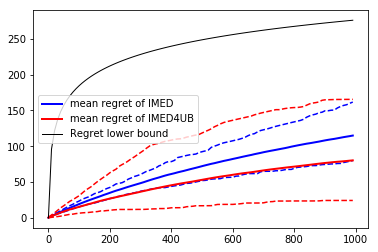

In [19]:
plt.clf()
plt.plot(tsave, np.mean(IMEDregret, 0), linewidth=2.0, color="b", label="mean regret of "+IMEDlearner.name())
plt.plot(tsave, np.quantile(IMEDregret, 0.95, 0), tsave, np.quantile(IMEDregret,0.05,0), linestyle="dashed", color="b")
plt.plot(tsave, np.mean(IMED4UBregret, 0), linewidth=2.0, color="r", label="mean regret of "+IMED4UBlearner.name())
plt.plot(tsave, np.quantile(IMED4UBregret, 0.95, 0), tsave, np.quantile(IMED4UBregret,0.05,0), linestyle="dashed", color="r")
plt.plot(tsave, LBregret, linewidth=1.0, color="k", label="Regret lower bound")
plt.legend()
plt.show()

### I.2. Unimodal Thomson Sampling (UTS)

#### Bonus
* Implement the UTS algorithm and compare its regret

## II. Lipschitz Bandits

We assume that $\mathcal{A} = \left\{0, \dots, A-1\right\}, A \geq 1$, and $ \mu : \begin{cases}
	\mathcal{A}   &  \to  \mathbb{R} \\
	a  &\mapsto  \mu_a
	\end{cases} $ is $k$-Lipschitz, where is $k$ is assumed to be known. That is, for all $ a, a' \!\in\! \mathcal{A}$, $|\mu_a - \mu_{a'}| \leq k\!\times\! |a - a'|$. It is further assumed that for each arm $a$,  $ \nu_{a} $ is a Gaussian distribution $ \mathcal{N}(\mu_a,1) $ , where $ \mu_a \in \mathbb{R} $ is the mean of the distribution $\nu_{a}$. We denote the structured set of Gaussian $k$-Lipschitz bandit distributions by 
	$$\mathcal{D}_{k\text{-Lip}} = \bigg\{\nu = (\nu_a)_{a \in \mathcal{A}}:\  \forall a \!\in\! \mathcal{A},\ \nu_a \sim \mathcal{N}(\mu_a,1) \text{ with } \mu_a \!\in\! \mathbb{R}\text{ and }\mu \text{ is } k\text{-Lipschitz}\bigg\}\,.$$

On a Gaussian $k$-Lipschitz bandit instance, the lower bounds tell us that the numbers of pulls satisfy **asymptotically** the following inequalities 

$$\forall a \in \mathcal{A}, \quad \sum_{a' \in \mathcal{V}_{a}} \mathrm{KL}\!\left(\mu_{a'},\,\mu_\star\!-\!k|a \!-\! a'|\right)\,N_{a'}(T) \geq \log(T)\,,$$
where $\mathcal{V}_{a} = \big\{a'\!\in\!\mathcal{A}\!:  \mu_{a'}\!<\! \mu_\star\!-\!k|a \!-\! a'|\big\}$ and $\mathrm{KL}(\mu,\mu')$ is the KL-divergence between the Gaussian distribution of mean $\mu$ and the Gaussian distribution of mean $\mu'$ (variances equal to $1$). The constant $C_{k\text{-Lip}}(\nu)$ resulting from the following linear programming may be called the **Lipschitz complexity** of the bandit problem:
$$  C_{k\text{-Lip}}(\nu) =
 \min \bigg\{\sum\limits_{a \in \mathcal{A}} (\mu_\star-\mu_a)\,n_{a}:\ n \in \mathbb{R}_+^{\mathcal{A}} \text{ s.t. } \forall a \in \mathcal{A},\sum_{a' \in \mathcal{V}_{a}} \mathrm{KL}\!\left(\mu_{a'},\,\mu_\star\!-\!k|a \!-\! a'|\right)\,n_{a'} \geq 1\bigg\}\,. 
$$

#### Questions
* Write a function that generate at random  $k$-Lipschitz Gaussian bandit instances
* Write a function that computes the complexity of a $k$-Lipschitz Gaussian bandit instance

### II.1. IMED for Lipschitz Bandits (IMED4LB)

For an arm $a \in \mathcal{A}$ and a time step $t\geq 1$, the IMED4LB index is defined as follows:
$$ I_a(t) = \sum\limits_{a ' \in \hat{\mathcal{V}}_{a}(t)}N_{a'}(t)\,\mathrm{KL}\!\left(\hat\mu_{a'}(t),\hat \mu_\star(t) - k |a - a'|\right)+ \log\!\left(N_{a'}(t)\right) \,, $$
where $\hat{\mathcal{V}}_{a}(t) = \big\{a'\!\in\!\mathcal{A}\!:  \hat\mu_{a'}(t)\!<\! \hat\mu_\star(t)\!-\!k|a \!-\! a'|\big\}$.

IMED4LB is the strategy that consists in pulling an arm with minimal index at each time step:
$$ a_{t+1} = \arg\!\min_{a \in \mathcal{A}}I_a(t)  \,.$$

#### Questions

* Implement the IMED4LB algorithm

* Compare the IMED4LB and IMED algorithms, including the asymptotic lower bound

* Compare the IMED4LB and IMED4UB algorithms for a both unimodal and $k$-Lipschitz Gaussian bandit instance, including the asymptotic lower bounds

* Study the influence of the accuracy on the Lipschitz constant $k$

### II.2. Combined KL-UCB (CKL-UCB)

#### Bonus
* Implement the CKL-UCB algorithm and compare its regret